# Imports and data

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import seaborn as sns
import utils.base_utils as bu
import utils.window_utils as wu
import numpy as np
from utils.macro_grouping import add_group_level, build_full_group_mapping, groups_as_array


# Bianchi period:
start_date = '1971-08-31'
end_date = '2018-12-31'

# start_date = pd.to_datetime('1979-01-01')
# end_date = pd.to_datetime('2024-12-31')

# end_date = '2025-06-30' # kr and gsw end date
maturities = [str(i) for i in range(12, 121) if i % 12 == 0] # select only yearly maturities

yields = bu.get_yields(type='lw', start=start_date, end=end_date, maturities=maturities) # type can be kr, lw, gsw
forward = bu.get_forward_rates(yields)
xr = bu.get_excess_returns(yields, horizon=12).dropna() # horizon=12 means holding for 12 months
fred_md_raw = bu.get_fred_data('data/2026-01-MD.csv', start=start_date, end=end_date) # this is aligned to the last day of the previous month, so we get the same number of observations as the yields data

monthly_yields = bu.get_yields(type='lw', start=start_date, end=end_date, maturities=[str(i) for i in range(1, 121)]) # needed for monthly holding period excess returns. Not available for gsw
monthly_xr = bu.get_excess_returns(monthly_yields, horizon=1).dropna() # calculate monthly excess returns for robustness

# At time t (end of month), we only know data for month t-1
fred_md = fred_md_raw.shift(1)  

# Drop dates outside the xr range
yields = yields.loc[yields.index <= xr.index[-1]]
forward = forward.loc[forward.index <= xr.index[-1]]
xr = xr.loc[xr.index <= xr.index[-1]]
fred_md = fred_md.loc[fred_md.index <= xr.index[-1]]
monthly_xr = monthly_xr.loc[monthly_xr.index <= xr.index[-1]]

# Backfill fred_md to avoid nans
fred_md = fred_md.bfill()

# Construct X with 3-level MultiIndex: (source, group, series)
s2g = build_full_group_mapping(fred_md, forward, yields)

X = pd.concat([fred_md, forward, yields],
               axis=1,
               keys=['fred', 'forward', 'yields'])

X = add_group_level(X, s2g, level_name='group')
X = X.sort_index(axis=1, level='group')
groups = groups_as_array(X, level='group')

y_all = xr[['24','36','48','60','72','84','96','108','120']].values
dates = xr.index

# Expanding window estimation

In [60]:
from models.base import *
from models.classical import *
from models.other import *
from models.ann import *
from models.gbt import *
from models.linear import *
from models.tree import *

# y = monthly_xr['120'].values # 1-month excess returns for robustness
y = xr['120'].values # 10-year excess returns
OOS_start = pd.Timestamp('1990-01-31')
# OOS_start = pd.Timestamp('1972-01-31')

seeds = [1]

for seed in seeds:
    print(f"Running seed {seed}...")
    # Models to test
    models = {
        # 'Lasso': LassoModel(series='forward'),
        'Ridge': RidgeModel(series='forward'),
        # 'ExtraTrees': ExtraTreesModel(features={
        #     'forward': {'method': 'raw'},
        # }),
        # 'Linear': LinearModel(),
        # 'PCA': PCABaselineModel(components=3, series='forward'),
        # 'GroupLasso': GroupLassoModel(alpha=0.01, groups=groups),
        # 'NN': ForwardRateANN(hidden_sizes=[3], do_grid_search=False,
        #                          trainer_kwargs={'epochs': 20, 'lr': 0.01, 'optimizer_type': 'adam', 'patience': 15}),
        # 'RW': RandomWalkModel(),
        # 'Mean': HistoricalMeanModel(),
        # 'CP': CochranePiazzesiModel(),
        # 'LN': LudvigsonNgModel(),
        # 'LN_BH': LudvigsonNgBauerHamiltonSpec(),
        # 'BianchiENet': BianchiElasticNet()
    }

    results = {}

    for name, model in models.items():
        print(f"Running {name}...")
        y_forecast = wu.expanding_window(model, X, y, dates, OOS_start, gap=0) # set gap to 11 for more realistic out-of-sample forecasts when using annual returns
        # Report both in your results table
        for bench_name, bench in [('zero (EH)', 'zero'), ('hist_mean (C-T)', 'hist_mean')]:
            r2 = wu.oos_r2(y, y_forecast, benchmark=bench)
            print(f"  R2_OOS [{bench_name}] = {r2:.4f}")        
        
    # Summary
    print("\n--- OOS R² Summary ---")
    for name, res in results.items():
        print(f"  {name}: {res['R2_OOS']:.4f}")

Running seed 1...
Running Ridge...


100%|██████████| 336/336 [00:14<00:00, 23.25it/s]

  R2_OOS [zero (EH)] = 0.1432
  R2_OOS [hist_mean (C-T)] = 0.0350

--- OOS R² Summary ---


<Axes: xlabel='date'>

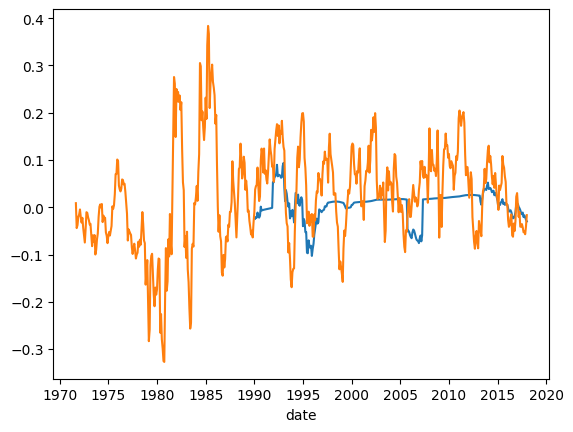

In [61]:
sns.lineplot(y=y_forecast, x=yields.index)
sns.lineplot(y=y, x=yields.index)

# Neural networks with multiple outputs:

In [ ]:
OOS_start = pd.Timestamp('1990-01-31')
# OOS_start = pd.Timestamp('2015-01-31')

X = pd.concat([fred_md, forward, yields],
               axis=1,
               keys=['fred', 'forward', 'yields'])

y = xr['120'].values # 10-year excess returns
# y = monthly_xr['120'].values # 1-month excess returns for robustness
y_all = xr[['24','36','48','60','72','84','96','108','120']].values

dates = xr.index

seeds = [1]

for seed in seeds:
    print(f"Running seed {seed}...")
    # Models to test
    models = {
        'SimpleANN': BianchiANN(hidden_size=3, series='forward')
    }

    results = {}

    for name, model in models.items():
        print(f"Running {name}...")
        y_forecast = wu.expanding_window(model, X, y_all, dates, OOS_start, gap=0) # set gap to 11 for more realistic out-of-sample forecasts when using annual returns
        r2s = wu.oos_r2(y_all, y_forecast, benchmark='hist_mean')

        print("\n--- OOS R² Summary ---")
        for mat, r2 in zip(['24','36','48','60','72','84','96','108','120'], r2s):
            print(f"  {mat}m: {r2:.4f}")

Running seed 1...
Running SimpleANN...


  0%|          | 0/336 [00:00<?, ?it/s]

100%|██████████| 336/336 [31:39<00:00,  5.65s/it]


--- OOS R² Summary ---
  24m: -0.1842
  36m: -0.0568
  48m: -0.2988
  60m: -0.1733
  72m: 0.0183
  84m: 0.0450
  96m: -0.0328
  108m: -0.0808
  120m: 0.0502


<Axes: xlabel='date'>

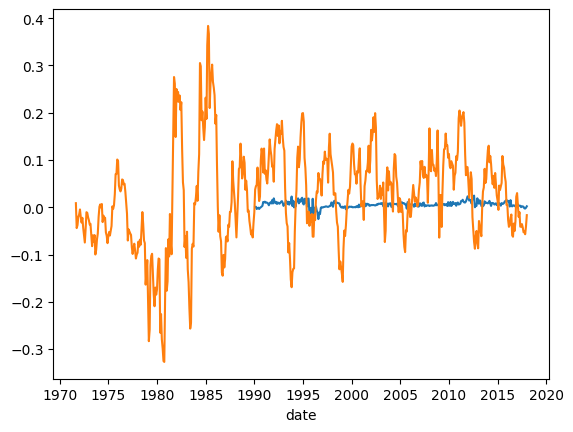

In [ ]:
sns.lineplot(y=y_forecast[:, 0], x=yields.index)
sns.lineplot(y=y, x=yields.index)

# Test in-sample fit

In [40]:
# full-sample R2 for comparison
y = xr['36'].values
model = HistoricalMeanModel()
model.fit(X, y)
r2_full = sklearn.metrics.r2_score(y, model.predict(X))
r2_full

TypeError: Input should have at least 1 dimension i.e. satisfy `len(x.shape) > 0`, got scalar `array(0.00979472)` instead.

<Axes: xlabel='date'>

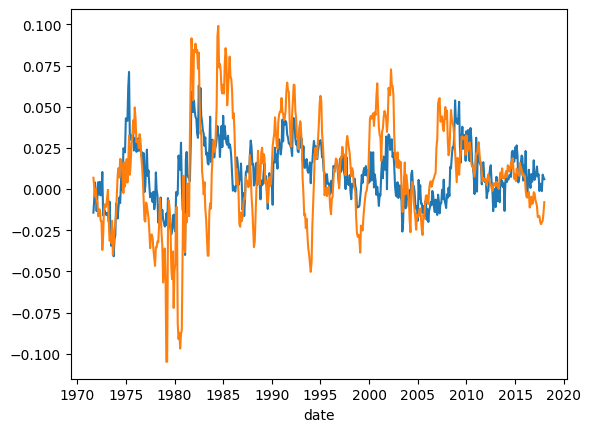

In [ ]:
sns.lineplot(y=model.predict(X), x=yields.index)
sns.lineplot(y=y, x=yields.index)